# $\beta$-Variational Autoencoder (VAE) with CNN

![dsprites dataset](https://storage.googleapis.com/tfds-data/visualization/fig/dsprites-2.0.0.png)

### Latent factor values

*   Color: white
*   Shape: square, ~~ellipse, heart~~
*   Scale: 6 values linearly spaced in [0.5, 1]
*   Orientation: ~~40~~ 20 values in [0, 2 pi]
*   Position X: ~~32~~ 16 values in [0, 1]
*   Position Y: ~~32~~ 16 values in [0, 1]

## Import libraries

In [1]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

## Set Hyperparameters

In [2]:
# Seed
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)

# Hyper-parameters for CNN VAE Model
# Data
img_size = (1, 64, 64)

# Model
latent_dim = 10
hidden_dim = 32
beta = 4. # For betaVAE

# Optimizer
learning_rate = 5e-4

# Training
batch_size = 128
epochs = 150

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Prepare DataLoader

### Download dataset

In [3]:
!git clone https://github.com/deepmind/dsprites-dataset.git
!rm -rf ./dsprites-dataset/.git* ./dsprites-dataset/*.md ./dsprites-dataset/LICENSE ./dsprites-dataset/*.ipynb ./dsprites-dataset/*.gif ./dsprites-dataset/*.hdf5

Cloning into 'dsprites-dataset'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Receiving objects: 100% (16/16), 28.85 MiB | 26.24 MiB/s, done.
Resolving deltas: 100% (4/4), done.


### Place the "dsprites_data.npz" inside the root directory

In [4]:
class dSpritesDataset(Dataset):
    def __init__(self):
        data = np.load(os.path.join('./dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'), encoding='bytes')
        data = data['imgs']
        data = data.reshape(3, 6, 40, 32, 32, 1, 64, 64)
        # shape, scale, orientation, X, Y
        self.data = data[0, :, ::2, ::2, ::2, :, :, :].reshape(-1, 1, 64, 64)
        self.size = self.data.shape[0]

    def __getitem__(self, index):
        return torch.from_numpy(self.data[index]).float()


    def __len__(self):
        return self.size

dset = dSpritesDataset()
train_loader = DataLoader(dset, batch_size=batch_size, shuffle=True, drop_last=True)

## Define VAE Model with CNN

### Define ConVAEModel by using ```nn.Sequential```

In [5]:
class ConVAEModel(nn.Module):
    def __init__(self, hidden_dim=32, latent_dim=10):
        super(ConVAEModel, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
          # ============================================================ #
          # TODO : Implement the encoder with nn.Sequential and convolutional layers (nn.Conv2d)
          # The encoder consists of the following layers
          # All the convolutional layers are followed by ReLU activation
          # hint - nn.Flatten()
          # 1. Conv2d : input_data (B, 1, 64, 64) -> (B, hidden_dim, 32, 32) w/ kernel_size=4, stride=2, padding=1
          # 2. Conv2d : (B, hidden_dim, 32, 32) -> (B, hidden_dim, 16, 16) w/ kernel_size=4, stride=2, padding=1
          # 3. Conv2d : (B, hidden_dim, 16, 16) -> (B, 2*hidden_dim, 8, 8) w/ kernel_size=4, stride=2, padding=1
          # 4. Conv2d : (B, 2*hidden_dim, 8, 8) -> (B, 2*hidden_dim, 4, 4) w/ kernel_size=4, stride=2, padding=1
          # 5. Conv2d : (B, 2*hidden_dim, 4, 4) -> (B, 8*hidden_dim, 1, 1) w/ kernel_size=4, stride=1
          # 5. fc : 8*hidden_dim -> 2*latent_dim
          # ============================================================ #
          nn.Conv2d(1, hidden_dim, 4, 2, 1),
          nn.ReLU(inplace=True),
          nn.Conv2d(hidden_dim, hidden_dim, 4, 2, 1),
          nn.ReLU(inplace=True),
          nn.Conv2d(hidden_dim, 2*hidden_dim, 4, 2, 1),
          nn.ReLU(inplace=True),
          nn.Conv2d(2*hidden_dim, 2*hidden_dim, 4, 2, 1),
          nn.ReLU(inplace=True),
          nn.Conv2d(2*hidden_dim, 8*hidden_dim, 4, 1),
          nn.ReLU(inplace=True),
          nn.Flatten(),
          nn.Linear(8*hidden_dim, 2*latent_dim)
        )
        self.decoder = nn.Sequential(
          # ============================================================ #
          # TODO : Implement the decoder with nn.Sequential and transposed convolution layers (nn.ConvTranspose2d)
          # The decoder consists of the following layers
          # All the transposed convolution layers are followed by ReLU activation except the last one, which is followed by Sigmoid
          # hint - nn.Unflatten()
          # 1. fc : latent_dim -> 8*hidden_dim
          # 2. ConvTranspose2d : (B, 8*hidden_dim, 1, 1) -> (B, 2*hidden_dim, 4, 4)
          # 3. ConvTranspose2d : (B, 2*hidden_dim, 4, 4) -> (B, 2*hidden_dim, 8, 8)
          # 4. ConvTranspose2d : (B, 2*hidden_dim, 8, 8) -> (B, hidden_dim, 16, 16)
          # 5. ConvTranspose2d : (B, hidden_dim, 16, 16) -> (B, hidden_dim, 32, 32)
          # 6. ConvTranspose2d : (B, hidden_dim, 32, 32) -> (B, 1, 64, 64)
          # ============================================================ #
          nn.Linear(latent_dim, 8*hidden_dim),
          nn.ReLU(inplace=True),
          nn.Unflatten(-1,(8*hidden_dim, 1, 1)),
          nn.ConvTranspose2d(8*hidden_dim, 2*hidden_dim, 4),
          nn.ReLU(inplace=True),
          nn.ConvTranspose2d(2*hidden_dim, 2*hidden_dim, 4, 2, 1),
          nn.ReLU(inplace=True),
          nn.ConvTranspose2d(2*hidden_dim, hidden_dim, 4, 2, 1),
          nn.ReLU(inplace=True),
          nn.ConvTranspose2d(hidden_dim, hidden_dim, 4, 2, 1),
          nn.ReLU(inplace=True),
          nn.ConvTranspose2d(hidden_dim, 1, 4, 2, 1),
          nn.Sigmoid()
        )

    def forward(self, x):
        # ============================================================ #
        # TODO
        # connect the encoder in decoder with reparametrization trick
        # input -> encoder -> mean, log_std -> z -> decoder
        # ============================================================ #
        # mean_log_std = None
        # mean, log_std = None
        mean_log_std = self.encoder(x)
        mean, log_std = torch.chunk(mean_log_std, 2, dim=1)

        if self.training:
            # z = None
            std = torch.exp(log_std)
            epsilon = torch.randn_like(std)
            z = mean + epsilon*std
        else:
            z = mean
        # out_x = None
        out_x = self.decoder(z)
        return out_x, mean, log_std

    def generate(self, z):
        return self.decoder(z)

### Define vae_loss with $\beta$

In [6]:
def vae_loss(x, output_x, mean, log_std, beta=1):
    # ============================================================ #
    # TODO : Implement the vae loss. This time, recon_loss, kl_loss shall be divided by the batch_size.
    # The reconstruction loss should be implemented as binary cross entropy.
    # ============================================================ #
    # recon_loss = None
    # kl_loss = None
    batch_size = x.size(0)

    # Reconstruction loss (binary cross-entropy)
    recon_loss = F.binary_cross_entropy(output_x, x, reduction='sum') / batch_size
    kl_ds = -0.5 * (1 + 2 * log_std - mean ** 2 - torch.exp(2*log_std))
    kl_loss = kl_ds.sum(1).mean(0, True)

    return recon_loss + beta * kl_loss, recon_loss, kl_loss

## Train VAE (with $\beta=1$)

### Model & Optimizer

In [7]:
model = ConVAEModel()
model.to(device)

# Optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

### Train epochs

In [8]:
model.train()
print('Start')
avg_train_loss = []
avg_recon_loss = []
avg_kl_loss = []
for epoch in range(epochs):
    train_loss = []
    recon_loss = []
    kl_loss = []
    for x in train_loader:
        x = x.to(device)

        # optimizer
        optimizer.zero_grad()

        # forward
        output_x, mean, log_std = model(x)
        loss, _recon_loss, _kl_loss = vae_loss(x, output_x, mean, log_std, beta=1)

        # for logging
        train_loss.append(loss.item())
        recon_loss.append(_recon_loss.item())
        kl_loss.append(_kl_loss.item())

        # sgd updates
        loss.backward()
        optimizer.step()
    avg_train_loss.append(np.mean(train_loss))
    avg_recon_loss.append(np.mean(recon_loss))
    avg_kl_loss.append(np.mean(kl_loss))
    print("Epoch:{:2}, AverageLoss:{:5.4g}, ReconLoss:{:5.4g}, KLLoss:{:5.4g}".format(epoch + 1, avg_train_loss[-1], avg_recon_loss[-1], avg_kl_loss[-1]))
print('Finish')

Start
Epoch: 1, AverageLoss:852.5, ReconLoss:845.6, KLLoss:6.866
Epoch: 2, AverageLoss:186.1, ReconLoss:161.3, KLLoss:24.75
Epoch: 3, AverageLoss:119.8, ReconLoss:95.51, KLLoss:24.32
Epoch: 4, AverageLoss:  117, ReconLoss:93.68, KLLoss: 23.3
Epoch: 5, AverageLoss:114.8, ReconLoss: 92.3, KLLoss:22.48
Epoch: 6, AverageLoss:113.9, ReconLoss:92.01, KLLoss:21.93
Epoch: 7, AverageLoss:112.5, ReconLoss:91.14, KLLoss:21.35
Epoch: 8, AverageLoss:111.8, ReconLoss:90.79, KLLoss:   21
Epoch: 9, AverageLoss:110.7, ReconLoss:90.08, KLLoss:20.64
Epoch:10, AverageLoss:110.1, ReconLoss:89.79, KLLoss:20.29
Epoch:11, AverageLoss:109.5, ReconLoss:89.59, KLLoss:19.95
Epoch:12, AverageLoss:108.6, ReconLoss:89.02, KLLoss: 19.6
Epoch:13, AverageLoss:108.3, ReconLoss:89.04, KLLoss:19.28
Epoch:14, AverageLoss:107.7, ReconLoss:88.68, KLLoss:18.97
Epoch:15, AverageLoss:106.8, ReconLoss:88.31, KLLoss:18.53
Epoch:16, AverageLoss:106.3, ReconLoss:88.07, KLLoss:18.22
Epoch:17, AverageLoss:106.3, ReconLoss:88.26, KLLo

### Plot Training loss curve of (1) train_loss, (2) reconstruction_loss, (3) kl loss

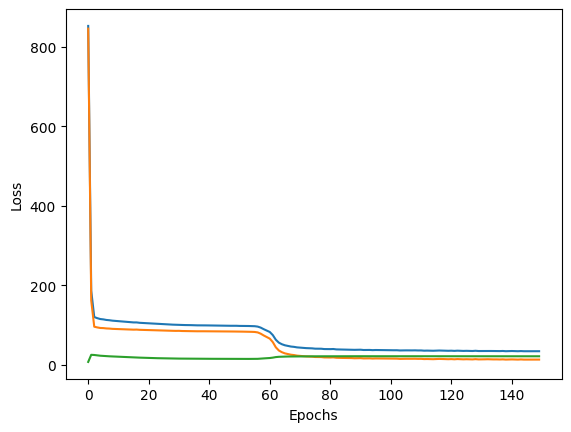

In [9]:
fig = plt.figure()
plt.plot(avg_train_loss)
plt.plot(avg_recon_loss)
plt.plot(avg_kl_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Comparison between the original and reconstructed images

Original images


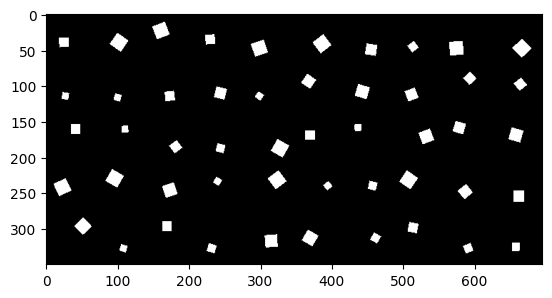

Reconstructed images


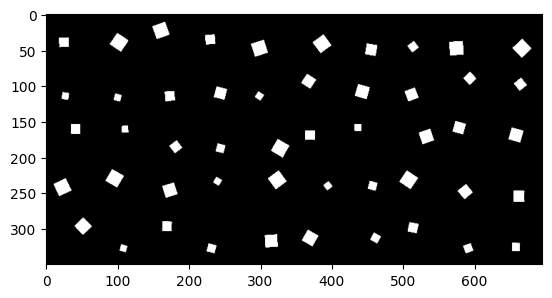

In [10]:
from torchvision.utils import make_grid

def show_image(x):
    x = x.clamp(0, 1)
    plt.imshow(np.transpose(x.numpy(), (1, 2, 0)))

def show_output_x(x):
    model.eval()
    with torch.no_grad():
        x = x.to(device)
        output_x, _, _ = model(x)
        output_x = output_x.cpu().view(-1, *img_size).clamp(0, 1)
        img_grid = make_grid(output_x[:50], 10, 5).numpy()
        plt.imshow(np.transpose(img_grid, (1, 2, 0)))
        plt.show()

x = next(iter(train_loader))

print('Original images')
show_image(make_grid(x[:50], 10, 5))
plt.show()

print('Reconstructed images')
show_output_x(x)

### Disentanglement visualization

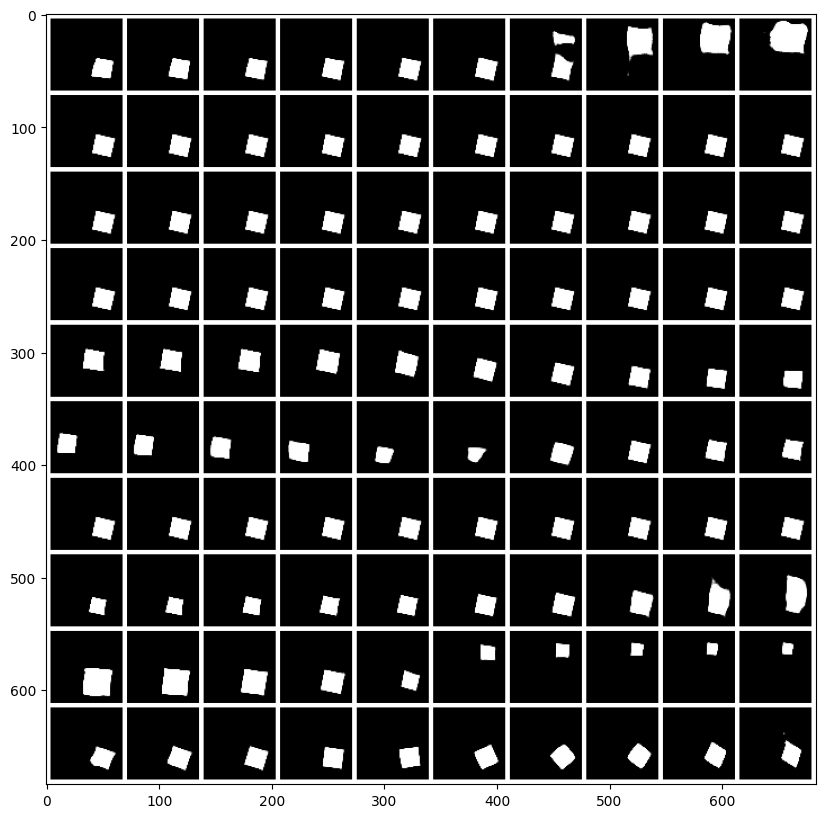

In [11]:
idx = random.randint(0, len(dset))
x = dset[idx].unsqueeze(0)
model.eval()
with torch.no_grad():
    z = model.encoder(x.to(device))
    z = z[:, :z.size(-1)//2]

temp = z.unsqueeze(1).expand(10, 10, 10).clone()
for i in range(10):
    temp[i, :, i] = torch.linspace(-4, 4, steps=10).to(device)
temp = temp.view(-1, 10)
with torch.no_grad():
    out_x = model.generate(temp).cpu()
plt.figure(figsize = (10,10))
show_image(make_grid(out_x, 10, 4, pad_value=1))
plt.show()

## Train $\beta$-VAE

### $\beta$-VAE model

In [12]:
beta_model = ConVAEModel()
beta_model.to(device)

# Optimizer
optimizer = Adam(beta_model.parameters(), lr=learning_rate)

### Train epochs

In [13]:
beta_model.train()
print('Start')
avg_train_loss = []
avg_recon_loss = []
avg_kl_loss = []
for epoch in range(epochs):
    train_loss = []
    recon_loss = []
    kl_loss = []
    for x in train_loader:
        x = x.to(device)

        # optimizer
        optimizer.zero_grad()

        # forward
        output_x, mean, log_std = beta_model(x)
        loss, _recon_loss, _kl_loss = vae_loss(x, output_x, mean, log_std, beta=beta)

        # for logging
        train_loss.append(loss.item())
        recon_loss.append(_recon_loss.item())
        kl_loss.append(_kl_loss.item())

        # sgd updates
        loss.backward()
        optimizer.step()
    avg_train_loss.append(np.mean(train_loss))
    avg_recon_loss.append(np.mean(recon_loss))
    avg_kl_loss.append(np.mean(kl_loss))
    print("Epoch:{:2}, AverageLoss:{:5.4g}, ReconLoss:{:5.4g}, KLLoss:{:5.4g}".format(epoch + 1, avg_train_loss[-1], avg_recon_loss[-1], avg_kl_loss[-1]))
print('Finish')

Start
Epoch: 1, AverageLoss:838.1, ReconLoss:833.9, KLLoss:1.035
Epoch: 2, AverageLoss:249.6, ReconLoss:201.3, KLLoss:12.07
Epoch: 3, AverageLoss:159.6, ReconLoss:110.8, KLLoss: 12.2
Epoch: 4, AverageLoss:148.7, ReconLoss:103.8, KLLoss:11.25
Epoch: 5, AverageLoss:145.6, ReconLoss:101.7, KLLoss:10.97
Epoch: 6, AverageLoss:143.7, ReconLoss:100.5, KLLoss:10.81
Epoch: 7, AverageLoss:142.6, ReconLoss:99.71, KLLoss:10.73
Epoch: 8, AverageLoss:141.5, ReconLoss:98.97, KLLoss:10.63
Epoch: 9, AverageLoss:140.8, ReconLoss:98.32, KLLoss:10.61
Epoch:10, AverageLoss:140.2, ReconLoss:97.98, KLLoss:10.54
Epoch:11, AverageLoss:139.4, ReconLoss:97.29, KLLoss:10.53
Epoch:12, AverageLoss:  139, ReconLoss:97.14, KLLoss:10.46
Epoch:13, AverageLoss:138.8, ReconLoss:97.08, KLLoss:10.43
Epoch:14, AverageLoss:138.1, ReconLoss:96.52, KLLoss: 10.4
Epoch:15, AverageLoss:137.8, ReconLoss:96.32, KLLoss:10.37
Epoch:16, AverageLoss:137.7, ReconLoss:96.23, KLLoss:10.37
Epoch:17, AverageLoss:137.3, ReconLoss:95.93, KLLo

### Plot Training loss curve of (1) train_loss, (2) reconstruction_loss, (3) kl loss

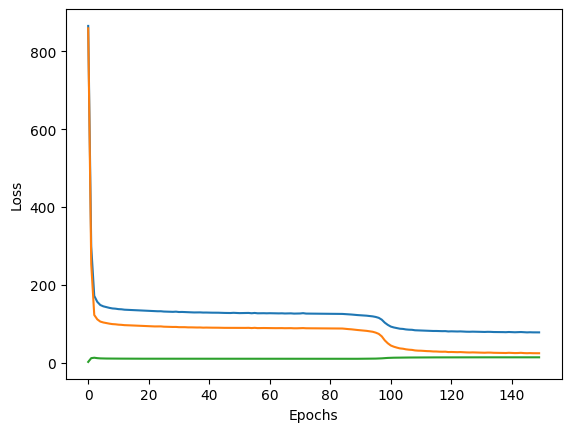

In [ ]:
fig = plt.figure()
plt.plot(avg_train_loss)
plt.plot(avg_recon_loss)
plt.plot(avg_kl_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Comparison between the original and reconstructed images

Original images


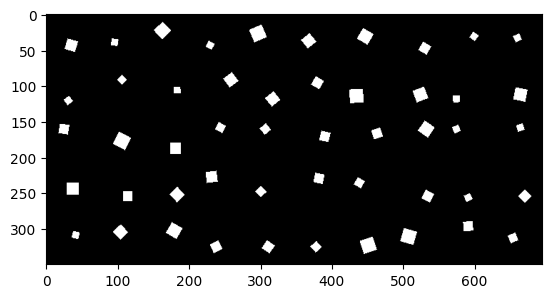

Reconstructed images


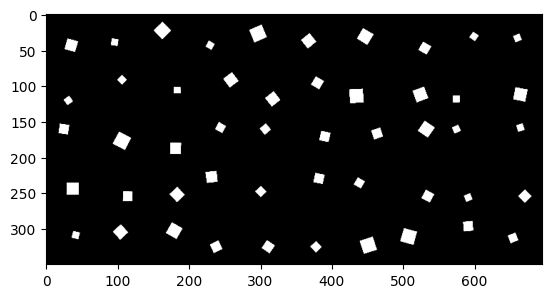

In [ ]:
def show_beta_output_x(x):
    beta_model.eval()
    with torch.no_grad():
        x = x.to(device)
        output_x, _, _ = beta_model(x)
        output_x = output_x.cpu().view(-1, *img_size).clamp(0, 1)
        img_grid = make_grid(output_x[:50], 10, 5).numpy()
        plt.imshow(np.transpose(img_grid, (1, 2, 0)))
        plt.show()

x = next(iter(train_loader))

print('Original images')
show_image(make_grid(x[:50], 10, 5))
plt.show()

print('Reconstructed images')
show_output_x(x)

### Disentanglement visualization

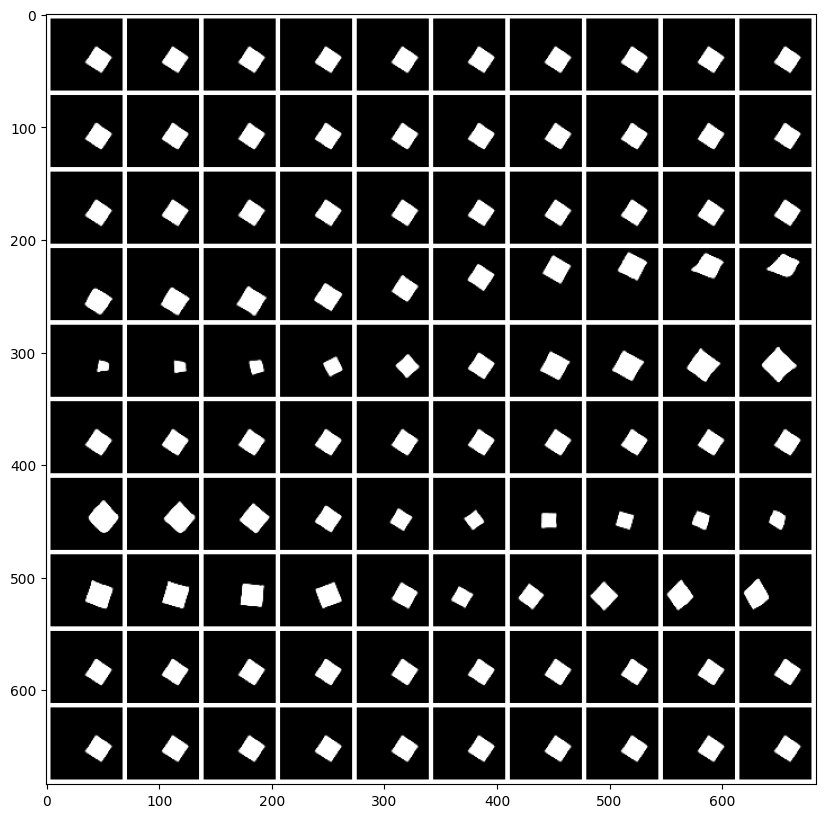

In [ ]:
idx = random.randint(0, len(dset))
x = dset[idx].unsqueeze(0)
beta_model.eval()
with torch.no_grad():
    z = beta_model.encoder(x.to(device))
    z = z[:, :z.size(-1)//2]

temp = z.unsqueeze(1).expand(10, 10, 10).clone()
for i in range(10):
    temp[i, :, i] = torch.linspace(-4, 4, steps=10).to(device)
temp = temp.view(-1, 10)
with torch.no_grad():
    out_x = beta_model.generate(temp).cpu()
plt.figure(figsize = (10,10))
show_image(make_grid(out_x, 10, 4, pad_value=1))
plt.show()

### Image generation comparison

In [ ]:
beta_model.eval()
model.eval()

with torch.no_grad():
    # Sample 100 latent vectors from the normal distribution
    z = torch.randn(100, latent_dim, device=device)

    # Generate images from the latent vectors
    gen_x = model.generate(z).cpu().view(-1, *img_size).clamp(0, 1)

    # Generate images from the latent vectors
    gen_x_beta = beta_model.generate(z).cpu().view(-1, *img_size).clamp(0, 1)

# Visualize
fig, ax = plt.subplots(figsize=(8, 8))
show_image(make_grid(gen_x.data,10,5))
plt.show()

# Visualize
fig, ax = plt.subplots(figsize=(8, 8))
show_image(make_grid(gen_x_beta.data,10,5))
plt.show()